In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
import scipy

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)

Environment specification:

python 3.7.12
numpy 1.19.5
scipy 1.4.1
seaborn 0.11.2
sklearn 1.0.2
pandas 1.3.5


### Ler ficheiros CSV como Dataframe:

In [ ]:
# kaggle dados de treino
data_df = pd.read_csv("train.csv")
# kaggle dados de teste
test_df = pd.read_csv("test.csv")

In [ ]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### Analise e organização de dados

O dataset consiste em 81 variaveis das quais 38 numericas.
Algumas não têm registo como por exemplo:"LotFrontage", "MasVnrArea".

O alvo de previsão é a  'SalePrice' por isso vamos analisar os resultados.

In [ ]:
#summario:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

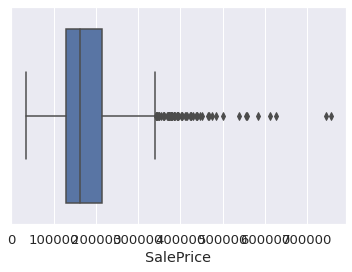

In [ ]:
sns.boxplot(data_df['SalePrice'])

Há 2 outliers com SalePrice=> 700K.

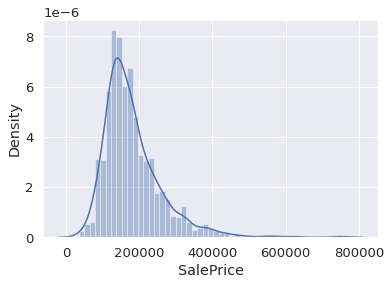

In [ ]:
# Grafico da densidade em função do SalePrice
sns.distplot(data_df['SalePrice'])

In [ ]:
# Positive Skeweness:
data_df['SalePrice'].skew()

1.8828757597682129

In [ ]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])

apliquei uma escala logaritmica para normalizaros dados

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

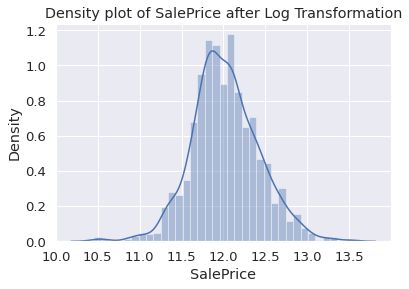

In [ ]:
# SalePrice transformação logaritmica
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")



In [ ]:
y_train = data_df["SalePrice"]

#### Contar o numero de Nan's por coluna

podemos reparar que há 3 colunas com uma percentagem altissima de Nan's

In [ ]:
col_nan = data_df.isna().sum() / data_df.shape[0]

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

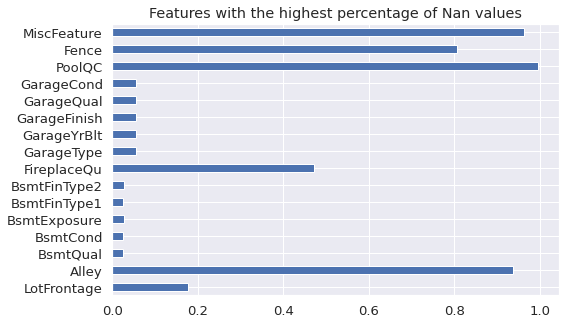

In [ ]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

defini 70% para o máximo de Nan's

In [ ]:

drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.70) if i==True]]
data_df = data_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop(drop_out_columns, axis=1)

**retirar o Id que não é necessário**

In [ ]:
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

**Removing columns that contain the same value in 100%**

retirar colunas de um só valor (Pave e AllPub)

In [ ]:
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

 **Remover outliers**

Vizualizar outliers do GrLivArea

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

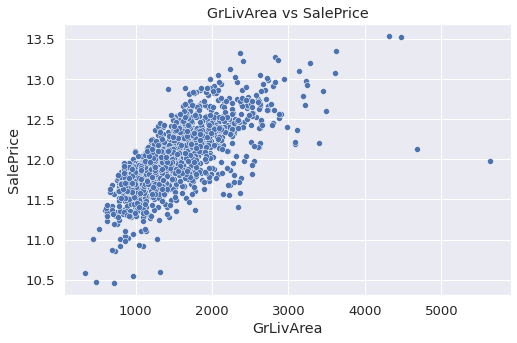

In [ ]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(data_df["GrLivArea"], data_df["SalePrice"])
# plt.vlines(4500, ymax=800000, ymin=0)
plt.title("GrLivArea vs SalePrice")

In [ ]:
# decidi remover'GrLivArea' maior que 4500
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)

In [ ]:
# Juntar train e test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

**LotFrontage feature**

como se trata da distância do passeio, é bem provavel que haja similariedade entre os mesmos bairro

In [ ]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [ ]:
# transformar para a mediana
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**transformar variaveis numericas que são categoricas.**

In [ ]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [ ]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

**substituir o resto dos valores em falta**

 os Nan foram substituidos por 0
 e o resto a mediana

In [ ]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"]
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [ ]:
# Gerar features numericas como input do DataFrameMapper.
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'median',
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'constant',
                                                         'fill_value' : 0,
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformação
imputed_features = imputed_median.transform(all_data)

# Por como dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


**Categoria para numerico**

In [ ]:
# Selecionar a categoria do features
cat_feats = all_data.select_dtypes(include=['object']).columns

De acordo com a descrição dos dados, criei uma lista de valores de conversão especificos para cada coluna

In [ ]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"),
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"),
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"),
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","NA"),
                  ("GarageCond","NA"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","No"),
                  ("GarageCond","No"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"),
                  ("Exterior2nd", "VinylSd"),
                  ("SaleType", "WD")]

função para converter os valores em falta em strings especificas

In [ ]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values
    into specific strings according to "conversion_list"

    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [ ]:
all_data = none_transform(all_data, none_conversion)

**Transformação das skewed features**

In [ ]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']]

# selecionar colunas com skew maior que 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Box-Cox deu melhores resultados que o Log-transformation logo usamos o BoxCox

In [ ]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

**Categorico para Numerico**


Algumas variaveis tais como ( **KitchenQual**, **GarageQual**) podem ser transformados numa ordem de valores.

In [ ]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d):
                return d

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

Alguns bairros parecem ser mais caros do que outros.

In [ ]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2,
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1,
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])


Correr a pipeline toda.

In [ ]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual",
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# Lista com o nome das colunas
cols = ["Neighborhood"] + order_feats

# Transformar train e test set
transformed_feats = label_encoder.fit_transform(all_data)

# features para dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [ ]:
original_features_df.shape

(2919, 10)

In [ ]:
# feature sem transformação
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [ ]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [ ]:
all_data.shape

(2919, 74)

In [ ]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

all_data = pd.concat([transformed_df, hot_one_features],axis=1)

## Dividir o train do test

In [ ]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


# Modelização
-----------------------------------

In [ ]:
X_train = train_preprocessed

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

**Definir função rmse**

In [ ]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

**Regressão linear**

In [ ]:
lr_model = make_pipeline(RobustScaler(), LinearRegression())

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00874257


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for Linear Regression: 41597.261


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Text(0.5, 0, 'Preços reais')

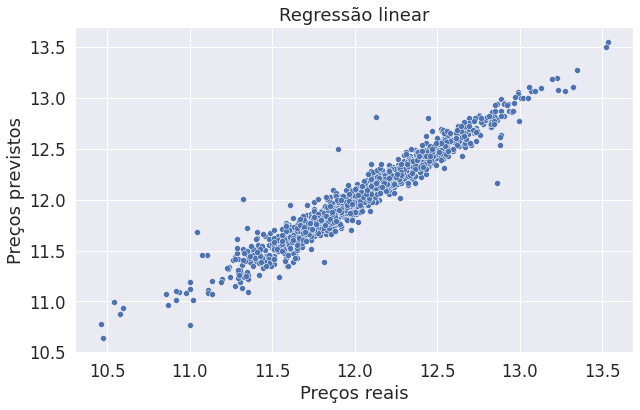

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(y_train, y_train_pred)
plt.title("Regressão linear")
plt.ylabel("Preços previstos")
plt.xlabel("Preços reais")



Text(0, 0.5, 'Residuos')

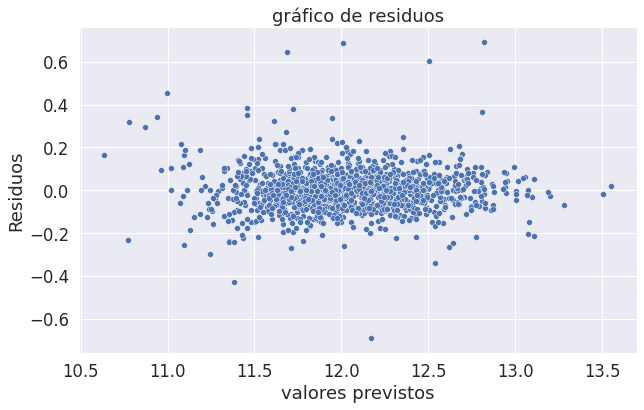

In [ ]:
# gráfico de residuos - o resultado deveria estar aleatoriamente distribuido por volta do zero
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train_pred - y_train)
plt.title("gráfico de residuos")
plt.xlabel("valores previstos")
plt.ylabel("Residuos")

** Modelo LASSO **

In [ ]:
lasso_model = make_pipeline(RobustScaler(),
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))


lasso_model.fit(X_train, y_train)
y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("erro quadrado médio = {:.8f}".format(MSE_train))
print("RMSE para o LASSO: {:.3f}".format(rmse(lasso_model)))



erro quadrado médio = 0.01199829


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE para o LASSO: 0.134


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


<function matplotlib.pyplot.show>

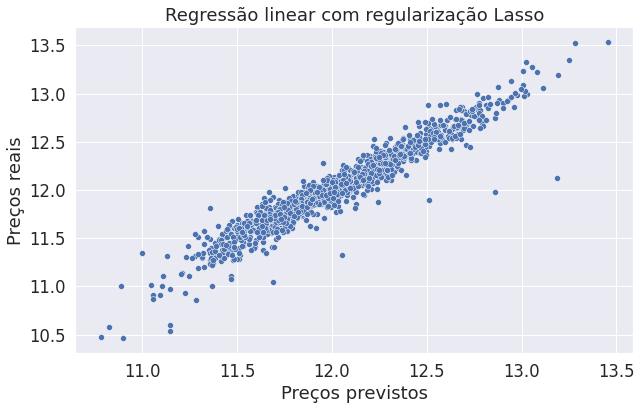

In [ ]:
# Gráfico das previsões
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Regressão linear com regularização Lasso")
plt.xlabel("Preços previstos")
plt.ylabel("Preços reais")
plt.show

**GradientBoostingRegressor**

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}

gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [ ]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000838


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for GB: 0.122


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


<function matplotlib.pyplot.show>

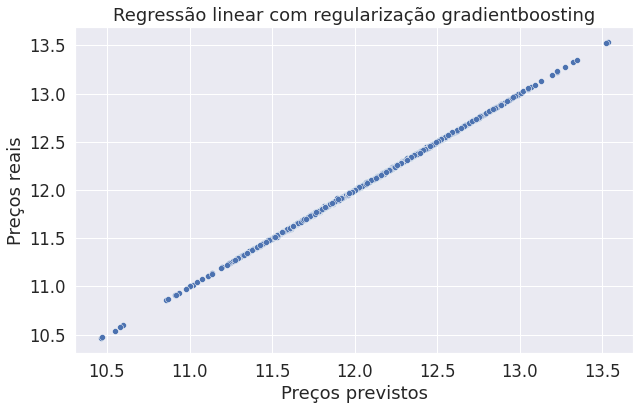

In [ ]:
# Gráfico das prvisões
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Regressão linear com regularização gradientboosting")
plt.xlabel("Preços previstos")
plt.ylabel("Preços reais")
plt.show

**XGB Regressor**

In [ ]:
xgbreg = xgb.XGBRegressor(objective="reg:squarederror", seed=0)
param_grid2 = {'n_estimators': [2000],
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}

xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))

KeyboardInterrupt: ignored

**ElasticNet**

In [ ]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006],
                        l1_ratio = [.9, .92],
                        random_state = 0,
                        cv=10)


In [ ]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

In [ ]:
print("erro quadratico medio = {:.8f}".format(MSE_train))
print("RMSE para ElasticNet: {:.3f}".format(rmse(en_model)))

In [ ]:
# Gráfico das prvisões
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Regressão linear com regularização ElasticNet")
plt.xlabel("Preços previstos")
plt.ylabel("Preços reais")
plt.show

**LightGBM**

In [ ]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("erro quadratico medio = {:.8f}".format(MSE_train))
print("RMSE para LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

In [ ]:
# Gráfico das prvisões
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Regressão linear com regularização LightGBM")
plt.xlabel("Preços previstos")
plt.ylabel("Preços reais")
plt.show

### Stacking

In [ ]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline


In [ ]:
lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = [0.0005],
                              random_state = 42, cv=5))

elasticnet_model = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=[0.0005],
                                        cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=800,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.23,
                                      feature_fraction_seed = 9, bagging_seed=9,
                                      min_data_in_leaf = 6,
                                      min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400,
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27,
                                     reg_alpha=0.00006))

In [ ]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model),
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

**Running**

In [ ]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

In [ ]:
en_preds = en_model.predict(test_preprocessed)

In [ ]:
lasso_preds = lasso_model.predict(test_preprocessed)

In [ ]:
stack_gen_preds = stack_model.predict(test_preprocessed)

In [ ]:
lgbm_preds = lgb_model.predict(test_preprocessed)

In [ ]:
# Previsão dos pesos
stack_preds = ((0.2*en_preds) + (0.25*lasso_preds) + (0.15*lgbm_preds) + (0.4*stack_gen_preds))

In [ ]:
predictions_df = pd.DataFrame(np.expm1(stack_preds),
                              index = test_preprocessed.index+1,
                              columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

##### Kaggle Submissão

In [ ]:
predictions_df["SalePrice"].to_csv("my_predictions.csv", header=True)